<a href="https://colab.research.google.com/github/leupimik/fishapp_modeltraining/blob/main/ML_Modell_MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import der einzelnen Bibliotheken

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# local_zip = "/content/gdrive/MyDrive/Daten_Images/images_categorized_6.zip"

In [ ]:

# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/gdrive/MyDrive/Test')
# zip_ref.close()


In [ ]:
local_file = '/content/gdrive/MyDrive/Test'

In [ ]:
PATH = os.path.join(os.path.dirname(local_file), 'Test')

In [ ]:
raw_dataset = os.path.join(PATH, 'images_categorized_6')

In [ ]:
#train_dir = os.path.join(PATH, 'images_edited')
#validation_dir = os.path.join(PATH, 'Test_Set')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
all_dataset = tf.keras.utils.image_dataset_from_directory(raw_dataset,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1746 files belonging to 21 classes.


In [ ]:
#validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
 #                                                                shuffle=True,
  #                                                               batch_size=BATCH_SIZE,
   #                                                              image_size=IMG_SIZE)

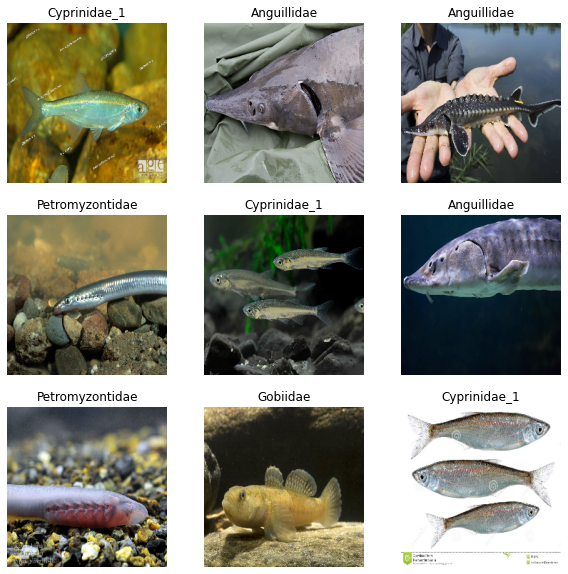

In [ ]:
# class_names = all_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in all_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
# train_size = int(0.7 * DATASET_SIZE)
# val_size = int(0.15 * DATASET_SIZE)
# test_size = int(0.15 * DATASET_SIZE)

# #full_dataset = tf.data.TFRecordDataset(FLAGS.input_file)
# full_dataset = full_dataset.shuffle()
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size)
# test_dataset = test_dataset.take(test_size)

In [ ]:
val_batches_1 = tf.data.experimental.cardinality(all_dataset)
test_dataset = all_dataset.take(val_batches_1 // 5)
train_dataset = all_dataset.skip(val_batches_1 // 5)

In [ ]:
#print(val_batches_1)

tf.Tensor(66, shape=(), dtype=int64)


In [ ]:
#print(val_batches_2)

tf.Tensor(13, shape=(), dtype=int64)


In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 44
Number of test batches: 11


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomContrast(factor, seed=None, **kwargs)
])

In [ ]:
# print(data_augmentation)

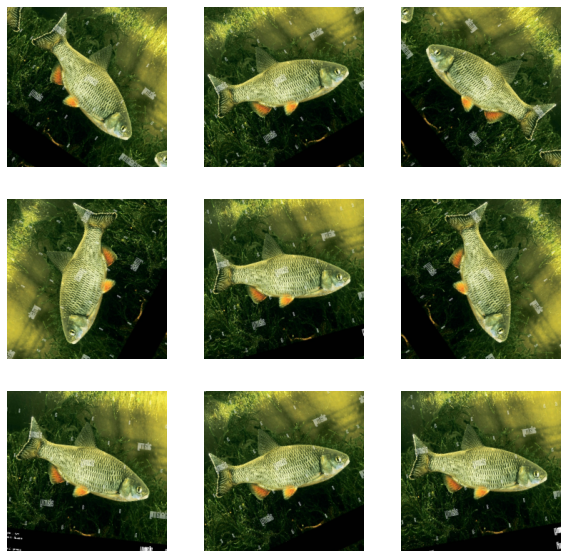

In [ ]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

Rescale Pixel Values

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


Feature extraction

Freeze the convolutional base

In [ ]:
base_model.trainable = False

Important note about BatchNormalization layers

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Add a classification head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(21)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 21)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),#learning_rate=base_learning_rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
len(model.trainable_variables)

2

Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(test_dataset)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -4.85
initial accuracy: 0.01


In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/Test/trained_weights.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset,
                    callbacks=[cp_callback]) # Pass callback to training)

                         

Epoch 1/10
53/53 [==============================] - 226s 4s/step - loss: -37.6194 - accuracy: 0.0066 - val_loss: -70.0706 - val_accuracy: 0.0125
Epoch 2/10
53/53 [==============================] - 33s 481ms/step - loss: -110.8243 - accuracy: 0.0078 - val_loss: -139.6706 - val_accuracy: 0.0094
Epoch 3/10
53/53 [==============================] - 35s 512ms/step - loss: -183.7437 - accuracy: 0.0072 - val_loss: -201.9578 - val_accuracy: 0.0063
Epoch 4/10
53/53 [==============================] - 33s 477ms/step - loss: -255.7911 - accuracy: 0.0084 - val_loss: -269.8084 - val_accuracy: 0.0094
Epoch 5/10
53/53 [==============================] - 35s 515ms/step - loss: -327.2829 - accuracy: 0.0072 - val_loss: -337.6258 - val_accuracy: 0.0125
Epoch 6/10
53/53 [==============================] - 37s 537ms/step - loss: -395.3956 - accuracy: 0.0090 - val_loss: -393.3571 - val_accuracy: 0.0094
Epoch 7/10
53/53 [==============================] - 37s 557ms/step - loss: -467.9292 - accuracy: 0.0084 - val_

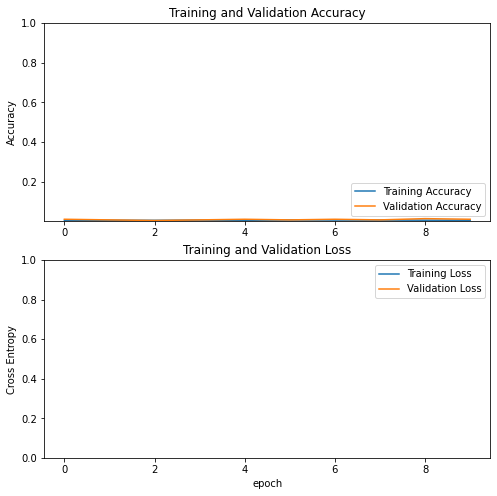

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Fine tuning

Un-freeze the top layers of the model

In [ ]:
# base_model.trainable = True

In [ ]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

Number of layers in the base model:  154


Compile the model

In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
#               metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# len(model.trainable_variables)

56

Continue training the model

In [ ]:
# fine_tune_epochs = 10
# total_epochs =  initial_epochs + fine_tune_epochs

# checkpoint_path = "/content/gdrive/MyDrive/Test/trained_weights.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history_fine = model.fit(train_dataset,
#                          epochs=total_epochs,
#                          initial_epoch=history.epoch[-1],
#                          validation_data=validation_dataset,
#                          callbacks=[cp_callback]) # Pass callback to training

In [ ]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

In [ ]:
# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()

Evaluation and prediction

In [ ]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

3/3 [==============================] - 4s 348ms/step - loss: -13176.7139 - accuracy: 0.0000e+00
Test accuracy : 0.0
